LTOD calculations

Take 3 days worth of gsx input swath data for a sensor
    for each swath locate all measurements that lie between 70 and 71 N (or S) latitude
    save the longitude and UTC for each measurement
    
Plot a histogram of the times - but it's more complicated than that - 
    for each time, which is in UTC, take the longitude and calculate what the ltod is for that
    UTC at that longitude.
    
    i.e. if the UTC is 02:48 and the longitude is -105, then the ltod is ((2*60)+48) + (-105*4)


In [1]:
from __future__ import print_function
%pylab inline
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import glob as glob
import time
import calendar
import numpy.ma as ma

Populating the interactive namespace from numpy and matplotlib


In [2]:
def seconds_to_midnight(seconds):
    """ This function calculates the number of seconds to midnight of the input
        time.  This is used to convert the scan times in the file to local time
        for that day """
    st = time.strptime("01.01.1987", "%d.%m.%Y")
    seconds_to_epoch = calendar.timegm(st)
    # get file epoch date in seconds since 1970
    str_date = time.gmtime(seconds + seconds_to_epoch)
    # get file date from number of seconds since 1987
    dmid = "%02d.%02d.%d" % (str_date.tm_mday, str_date.tm_mon, str_date.tm_year)
    utc_midnight = time.strptime(dmid, "%d.%m.%Y")
    utc_seconds_to_midnight = calendar.timegm(utc_midnight)
    # get midnight of file date in seconds
    return (utc_seconds_to_midnight - seconds_to_epoch)

In [3]:
def create_ltod(files, lat_min=70., lat_max=71.):
    """ This function takes a list of gsx swath files as an argument and
        calculates the local time of each measurement in a specified latitude band
        It returns a 1-D array of the local times (in hours wrt midnight), 
        suitable for creating a histogram """
    
    fid = Dataset(files[0], 'r', 'NETCDF4')
    lat = fid.variables['latitude_loc1'][:]
    lon = fid.variables['longitude_loc1'][:]
    scantime = fid.variables['scan_time_loc1'][:]
    meas = len(fid.dimensions['measurements_loc1'])
    scan_time = array([scantime,]*meas).transpose()
    lat_all = lat.flatten()
    lon_all = lon.flatten()
    offset_seconds = seconds_to_midnight(scantime[0]) # get the offset to midnight for the first scanline
    scantime_all = scan_time.flatten() - offset_seconds
    fid.close()
    for fil in files[1:-1]:
        #print (fil)
        fid = Dataset(fil, 'r', 'NETCDF4')
        scantime = fid.variables['scan_time_loc1'][:]
        if (len(scantime)):
            meas = len(fid.dimensions['measurements_loc1'])
            scan_time = array([scantime,]*meas).transpose()
            offset_seconds = seconds_to_midnight(scantime[0])
            scantime_all = np.concatenate((scantime_all, (scan_time.flatten() - offset_seconds)))
        else:
            fid.close()
            continue         
        lat = fid.variables['latitude_loc1'][:]
        lon = fid.variables['longitude_loc1'][:]
        lat_all = np.concatenate((lat_all, lat.flatten()))
        lon_all = np.concatenate((lon_all, lon.flatten()))
        fid.close()
    latm = ma.masked_where((lat_all < lat_min), lat_all)
    lat_band = ma.masked_where( latm > lat_max, latm)
    lon_band = ma.masked_array(lon_all, lat_band.mask)
    scantime_band = ma.masked_array(scantime_all, lat_band.mask)
    final_times = scantime_band + (lon_band*4*60.0)
    ftimes = final_times/3600.
    ftimes[ftimes > 24.0] = ftimes[ftimes > 24.0] - 24.0
    ftimes[ftimes < 0.] = ftimes[ftimes < 0.] + 24.0
    return ftimes

In [4]:
%cd /projects/PMESDR/vagrant

/projects/PMESDR/vagrant


In [5]:
fil_F10 = sort(glob.glob("F10-1996/*F10_D1996010*.nc"))
fil_F11 = sort(glob.glob("F11-2000/*F11_D2000051*.nc"))
fil_F15 = sort(glob.glob("F15-2000/*F15_D2000022*.nc"))
fil_F17 = sort(glob.glob("F17-2008/*F17_D2008123*.nc"))
fil_smmr = sort(glob.glob("pmadden/smmr_1984/gsx_84.35*.nc"))
fil_F14 = sort(glob.glob("F14-2008/*F14_D2008022*.nc"))
fil_F08 = sort(glob.glob("F08-1989/*.nc"))
fil_F16 = sort(glob.glob("F16-2006/*F16_D2006010*.nc"))
fil_F13 = sort(glob.glob("F13-2003/*F13_D2003010*.nc"))
fil_F18 = sort(glob.glob("F18-2010/*F18_D201004*.nc"))
fil_amsre = sort(glob.glob("prototype-data/AMSRE/*.nc"))

In [6]:
print (len(fil_F10), len(fil_F11), len(fil_F15), len(fil_F17), len(fil_smmr), len(fil_F08))

129 98 99 28 71 28


In [8]:
print (len(fil_amsre), len(fil_F16), len(fil_F13), len(fil_F14), len(fil_F18))

12 127 127 14 14


In [9]:
ftn_F08 = create_ltod(fil_F08, lat_min = 70.0, lat_max = 71.0)
fts_F08 = create_ltod(fil_F08, lat_max = -70.0, lat_min = -71.0)
ftn_smmr = create_ltod(fil_smmr[30:-1], lat_min = 70.0, lat_max = 71.0)
fts_smmr = create_ltod(fil_smmr[30:-1], lat_max = -70.0, lat_min = -71.0)
ftn_F17 = create_ltod(fil_F17, lat_min = 70.0, lat_max = 71.0)
fts_F17 = create_ltod(fil_F17, lat_max = -70.0, lat_min = -71.0)
ftn_F15 = create_ltod(fil_F15[70:-1], lat_min = 70.0, lat_max = 71.0)
fts_F15 = create_ltod(fil_F15[70:-1], lat_max = -70.0, lat_min = -71.0)
ftn_F10 = create_ltod(fil_F10[0:30], lat_min = 70.0, lat_max = 71.0)
fts_F10 = create_ltod(fil_F10[0:30], lat_max = -70.0, lat_min = -71.0)
ftn_F11 = create_ltod(fil_F11[50:-1], lat_min = 70.0, lat_max = 71.0)
fts_F11 = create_ltod(fil_F11[50:-1], lat_max = -70.0, lat_min = -71.0)
ftn_F16 = create_ltod(fil_F16[90:-1], lat_min = 70.0, lat_max = 71.0)
fts_F16 = create_ltod(fil_F16[90:-1], lat_max = -70.0, lat_min = -71.0)
ftn_F13 = create_ltod(fil_F13[0:40], lat_min = 70.0, lat_max = 71.0)
fts_F13 = create_ltod(fil_F13[0:40], lat_max = -70.0, lat_min = -71.0)
ftn_F14 = create_ltod(fil_F14, lat_min = 70.0, lat_max = 71.0)
fts_F14 = create_ltod(fil_F14, lat_max = -70.0, lat_min = -71.0)
ftn_F18 = create_ltod(fil_F18, lat_min = 70.0, lat_max = 71.0)
fts_F18 = create_ltod(fil_F18, lat_max = -70.0, lat_min = -71.0)
ftn_amsre = create_ltod(fil_amsre, lat_min = 70.0, lat_max = 71.0)
fts_amsre = create_ltod(fil_amsre, lat_max = -70.0, lat_min = -71.0)

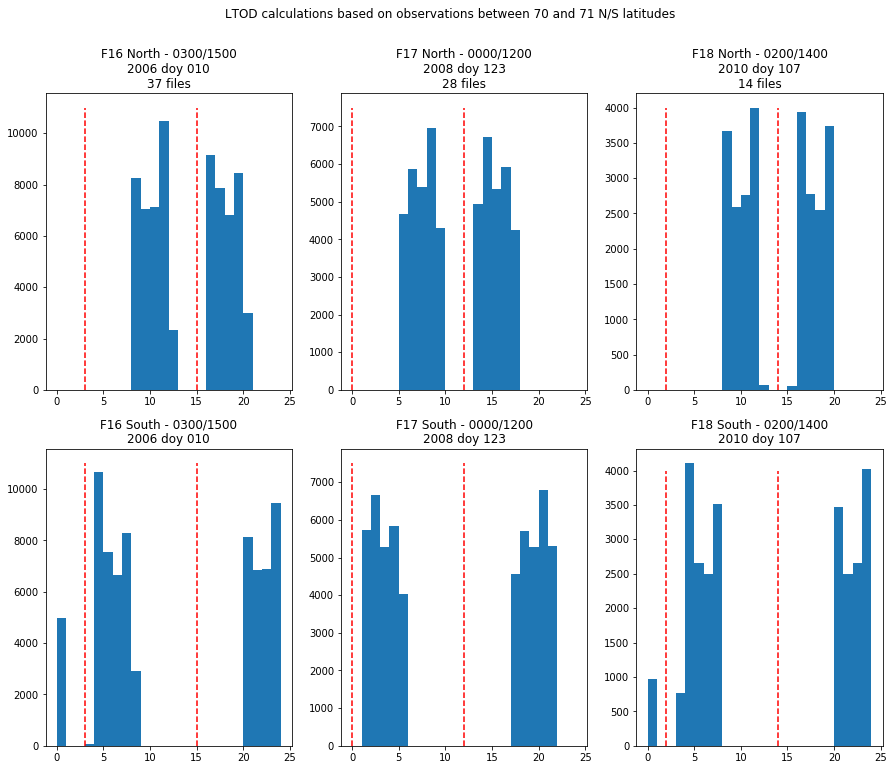

In [10]:
fig = plt.figure(figsize=(15,12))
plt.suptitle('LTOD calculations based on observations between 70 and 71 N/S latitudes')
a = fig.add_subplot(2,3,1)
plt.hist(ftn_F16,bins=(np.arange(25)))
plt.plot([15, 15], [0, 11000], color='r', linestyle='--')
plt.plot([3, 3], [0, 11000], color='r', linestyle='--')
a.set_title('F16 North - 0300/1500\n2006 doy 010\n37 files')
a = fig.add_subplot(2,3,2)
plt.hist(ftn_F17, bins = (np.arange(25)))
plt.plot([12, 12], [0, 7500], color='r', linestyle='--')
plt.plot([0, 0], [0, 7500], color='r', linestyle='--')
a.set_title('F17 North - 0000/1200\n2008 doy 123\n28 files')
a = fig.add_subplot(2,3,3)
a.set_title('F18 North - 0200/1400\n2010 doy 107\n14 files')
plt.hist(ftn_F18, bins = (np.arange(25)))
plt.plot([14, 14], [0, 4000], color='r', linestyle='--')
plt.plot([2, 2], [0, 4000], color='r', linestyle='--')
a = fig.add_subplot(2,3,4)
plt.hist(fts_F16, bins = (np.arange(25)))
plt.plot([15, 15], [0, 11000], color='r', linestyle='--')
plt.plot([3, 3], [0, 11000], color='r', linestyle='--')
a.set_title('F16 South - 0300/1500\n2006 doy 010')
a = fig.add_subplot(2,3,5)
plt.plot([12, 12], [0, 7500], color='r', linestyle='--')
plt.plot([0, 0], [0, 7500], color='r', linestyle='--')
plt.hist(fts_F17, bins = (np.arange(25)))
a.set_title('F17 South - 0000/1200\n2008 doy 123')
a = fig.add_subplot(2,3,6)
plt.hist(fts_F18, bins = (np.arange(25)))
plt.plot([14, 14], [0, 4000], color='r', linestyle='--')
plt.plot([2, 2], [0, 4000], color='r', linestyle='--')
a.set_title('F18 South - 0200/1400\n2010 doy 107')
plt.show
fig.savefig('/projects/PMESDR/vagrant/mhardman/SSMIS.png')

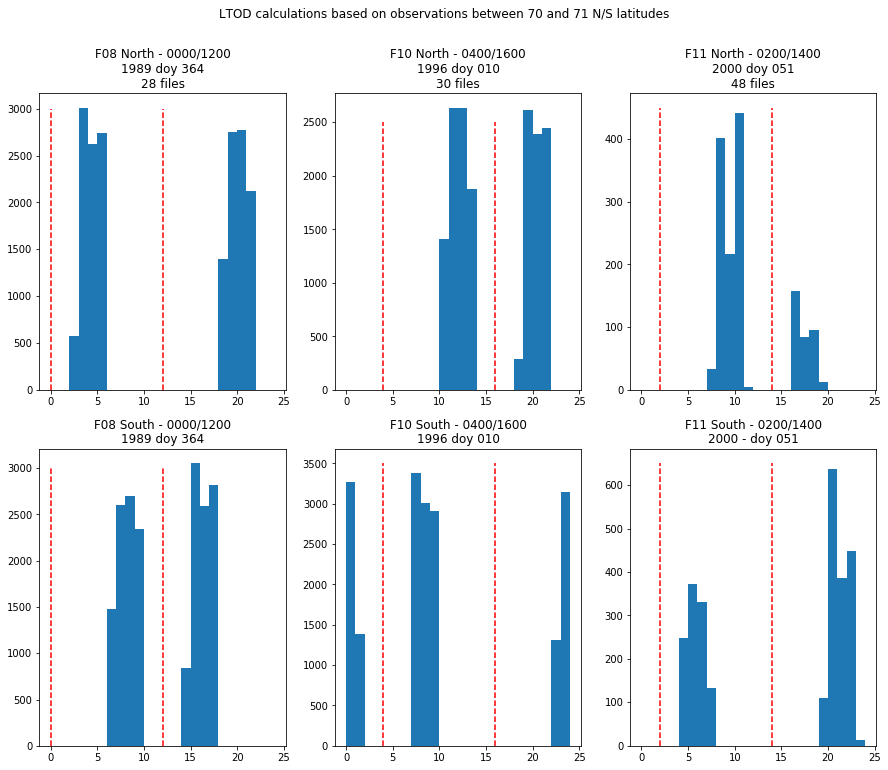

In [11]:
fig = plt.figure(figsize=(15,12))
plt.suptitle('LTOD calculations based on observations between 70 and 71 N/S latitudes')
a = fig.add_subplot(2,3,1)
plt.hist(ftn_F08, bins=(np.arange(25)))
a.set_title('F08 North - 0000/1200\n1989 doy 364\n28 files')
plt.plot([12, 12], [0, 3000], color='r', linestyle='--')
plt.plot([0, 0], [0, 3000], color='r', linestyle='--')
a = fig.add_subplot(2,3,2)
plt.hist(ftn_F10,bins=(np.arange(25)))
a.set_title('F10 North - 0400/1600\n1996 doy 010\n30 files')
plt.plot([16, 16], [0, 2500], color='r', linestyle='--')
plt.plot([4, 4], [0, 2500], color='r', linestyle='--')
a = fig.add_subplot(2,3,3)
plt.hist(ftn_F11, bins = (np.arange(25)))
a.set_title('F11 North - 0200/1400\n2000 doy 051\n48 files')
plt.plot([14, 14], [0, 450], color='r', linestyle='--')
plt.plot([2, 2], [0, 450], color='r', linestyle='--')
a = fig.add_subplot(2,3,4)
plt.hist(fts_F08, bins = (np.arange(25)))
a.set_title('F08 South - 0000/1200\n1989 doy 364')
plt.plot([12, 12], [0, 3000], color='r', linestyle='--')
plt.plot([0, 0], [0, 3000], color='r', linestyle='--')
a = fig.add_subplot(2,3,5)
plt.hist(fts_F10, bins = (np.arange(25)))
a.set_title('F10 South - 0400/1600\n1996 doy 010')
plt.plot([16, 16], [0, 3500], color='r', linestyle='--')
plt.plot([4, 4], [0, 3500], color='r', linestyle='--')
a = fig.add_subplot(2,3,6)
plt.hist(fts_F11, bins = (np.arange(25)))
a.set_title('F11 South - 0200/1400\n2000 - doy 051')
plt.plot([14, 14], [0, 650], color='r', linestyle='--')
plt.plot([2, 2], [0, 650], color='r', linestyle='--')
plt.show
fig.savefig('/projects/PMESDR/vagrant/mhardman/F081011.png')

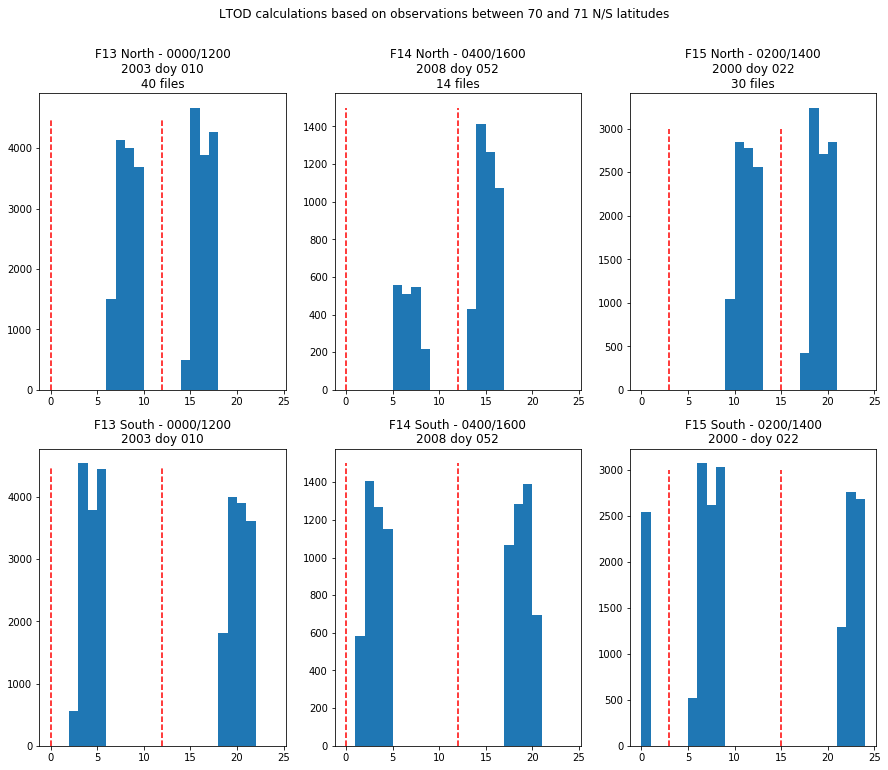

In [12]:
fig = plt.figure(figsize=(15,12))
plt.suptitle('LTOD calculations based on observations between 70 and 71 N/S latitudes')
a = fig.add_subplot(2,3,1)
plt.hist(ftn_F13, bins=(np.arange(25)))
a.set_title('F13 North - 0000/1200\n2003 doy 010\n40 files')
plt.plot([12, 12], [0, 4500], color='r', linestyle='--')
plt.plot([0, 0], [0, 4500], color='r', linestyle='--')
a = fig.add_subplot(2,3,2)
plt.hist(ftn_F14,bins=(np.arange(25)))
a.set_title('F14 North - 0400/1600\n2008 doy 052\n14 files')
plt.plot([12, 12], [0, 1500], color='r', linestyle='--')
plt.plot([0, 0], [0, 1500], color='r', linestyle='--')
a = fig.add_subplot(2,3,3)
plt.hist(ftn_F15, bins = (np.arange(25)))
a.set_title('F15 North - 0200/1400\n2000 doy 022\n30 files')
plt.plot([15, 15], [0, 3000], color='r', linestyle='--')
plt.plot([3, 3], [0, 3000], color='r', linestyle='--')
a = fig.add_subplot(2,3,4)
plt.hist(fts_F13, bins = (np.arange(25)))
a.set_title('F13 South - 0000/1200\n2003 doy 010')
plt.plot([12, 12], [0, 4500], color='r', linestyle='--')
plt.plot([0, 0], [0, 4500], color='r', linestyle='--')
a = fig.add_subplot(2,3,5)
plt.hist(fts_F14, bins = (np.arange(25)))
a.set_title('F14 South - 0400/1600\n2008 doy 052')
plt.plot([12, 12], [0, 1500], color='r', linestyle='--')
plt.plot([0, 0], [0, 1500], color='r', linestyle='--')
a = fig.add_subplot(2,3,6)
plt.hist(fts_F15, bins = (np.arange(25)))
a.set_title('F15 South - 0200/1400\n2000 - doy 022')
plt.plot([15, 15], [0, 3000], color='r', linestyle='--')
plt.plot([3, 3], [0, 3000], color='r', linestyle='--')
plt.show
fig.savefig('/projects/PMESDR/vagrant/mhardman/F131415.png')

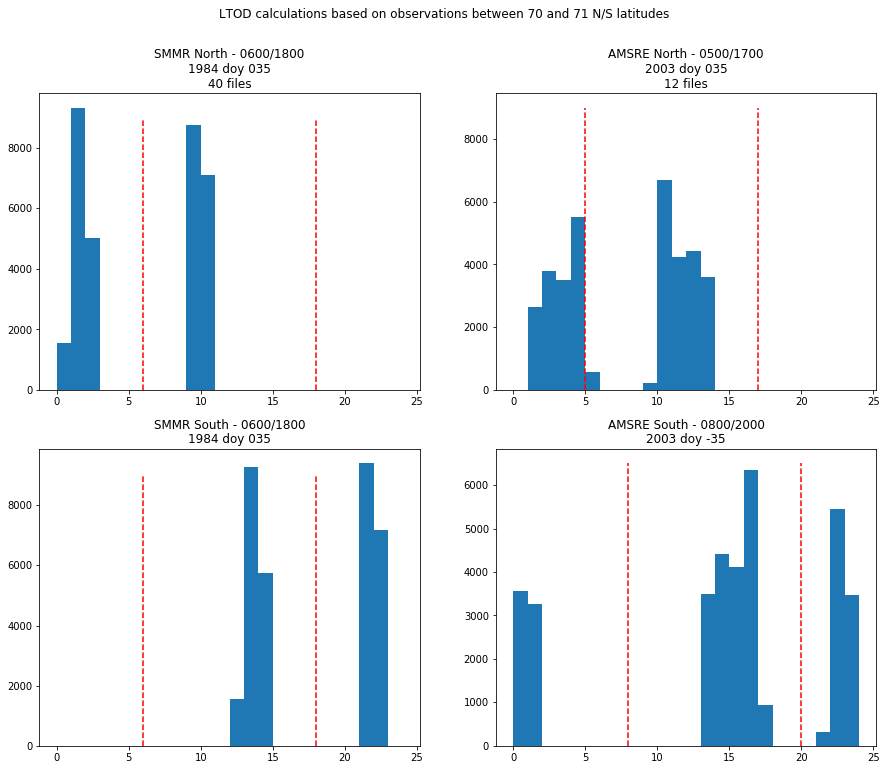

In [16]:
fig = plt.figure(figsize=(15,12))
plt.suptitle('LTOD calculations based on observations between 70 and 71 N/S latitudes')
a = fig.add_subplot(2,2,1)
plt.hist(ftn_smmr, bins=(np.arange(25)))
a.set_title('SMMR North - 0600/1800\n1984 doy 035\n40 files') 
plt.plot([6, 6], [0, 9000], color='r', linestyle='--')
plt.plot([18, 18], [0, 9000], color='r', linestyle='--')
a = fig.add_subplot(2,2,3)
plt.hist(fts_smmr, bins=(np.arange(25)))
a.set_title('SMMR South - 0600/1800\n1984 doy 035')
plt.plot([6, 6], [0, 9000], color='r', linestyle='--')
plt.plot([18, 18], [0, 9000], color='r', linestyle='--')
a = fig.add_subplot(2,2,2)
plt.hist(ftn_amsre, bins=(np.arange(25)))
a.set_title('AMSRE North - 0500/1700\n2003 doy 035\n12 files')
plt.plot([5, 5], [0, 9000], color='r', linestyle='--')
plt.plot([17, 17], [0, 9000], color='r', linestyle='--')
a = fig.add_subplot(2,2,4)
plt.hist(fts_amsre, bins=(np.arange(25)))
a.set_title('AMSRE South - 0800/2000\n2003 doy -35')
plt.plot([8, 8], [0, 6500], color='r', linestyle='--')
plt.plot([20, 20], [0, 6500], color='r', linestyle='--')
plt.show()
fig.savefig('/projects/PMESDR/vagrant/mhardman/Fsmmr-amsre.png')